In [ ]:
pip install torch

In [5]:
pip install timm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 847.2 kB/s eta 0:00:0031m55.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 19.4 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
print("Starting")
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),  # Add vertical flip
    transforms.RandomRotation(degrees=30),  # Increase rotation range
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Add scaling and translation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets with updated paths
train_dataset = ImageFolder("processed_data/train", transform=train_transform)
val_dataset = ImageFolder("processed_data/val", transform=val_transform)
test_dataset = ImageFolder("processed_data/test", transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Verify dataset sizes
print(f"Training dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

Starting
Training dataset size: 4973 images
Validation dataset size: 704 images
Test dataset size: 699 images


In [3]:
import torch
import torch.nn as nn
import timm


class EfficientNetWithSepConv(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Load the base model
        self.base = timm.create_model("efficientnet_b0", pretrained=True, features_only=False)
        
        # Extract the features before the classifier
        self.base.classifier = nn.Identity()
        self.base.global_pool = nn.Identity()
        
        # Define input features for the separable convolution
        in_features = 1280
        
        self.sep_conv = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, groups=in_features, padding=1),
            nn.Conv2d(in_features, 256, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Use the forward method without accessing .features
        x = self.base(x)
        # At this point, x should be the output from the EfficientNet's feature extractor
        x = self.sep_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

print("Done")

Done


In [5]:
# Training setup
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetWithSepConv(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # new learning rate
print("DONE")


DONE


In [6]:
class_weights = torch.tensor([1.0, 1.2, 1.0, 1.0])  # Higher weight for water class
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [7]:
torch.cuda.empty_cache()

In [8]:

print("Starting")
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

Starting
Epoch 1, Loss: 0.19747445522210536
Validation Accuracy: 98.15%
Epoch 2, Loss: 0.03568044523648822
Validation Accuracy: 99.15%
Epoch 3, Loss: 0.02887603851969545
Validation Accuracy: 98.01%
Epoch 4, Loss: 0.02907076586957257
Validation Accuracy: 99.43%
Epoch 5, Loss: 0.020734241183023326
Validation Accuracy: 99.57%
Epoch 6, Loss: 0.010374480682143118
Validation Accuracy: 99.15%
Epoch 7, Loss: 0.018832329555805653
Validation Accuracy: 99.01%
Epoch 8, Loss: 0.014997322876857093
Validation Accuracy: 99.86%
Epoch 9, Loss: 0.011460256446764853
Validation Accuracy: 100.00%
Epoch 10, Loss: 0.008363580979885928
Validation Accuracy: 99.86%
Epoch 11, Loss: 0.008458301499138962
Validation Accuracy: 99.43%
Epoch 12, Loss: 0.012214129455596542
Validation Accuracy: 98.72%
Epoch 13, Loss: 0.010258974001398876
Validation Accuracy: 99.29%
Epoch 14, Loss: 0.008146113010018151
Validation Accuracy: 99.15%
Epoch 15, Loss: 0.0027381478492036248
Validation Accuracy: 99.72%
Epoch 16, Loss: 0.006006536

In [9]:
# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.71%


In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Collect predictions and labels from the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
class_names = ["cloudy", "desert", "green_area", "water"]
print("Classification Report on Test Set:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Compute per-class accuracy
per_class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_correct = sum((np.array(all_labels) == i) & (np.array(all_preds) == i))
    class_total = sum(np.array(all_labels) == i)
    per_class_accuracy[class_name] = 100 * class_correct / class_total
    print(f"Accuracy for {class_name}: {per_class_accuracy[class_name]:.2f}%")


Classification Report on Test Set:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       150
      desert       1.00      1.00      1.00       249
  green_area       0.99      1.00      0.99       150
       water       1.00      0.99      0.99       150

    accuracy                           1.00       699
   macro avg       1.00      1.00      1.00       699
weighted avg       1.00      1.00      1.00       699

Accuracy for cloudy: 100.00%
Accuracy for desert: 100.00%
Accuracy for green_area: 100.00%
Accuracy for water: 98.67%


Satellite Image Classifier
-------------------------


Enter the path to your satellite image (or 'quit' to exit):  data/green_area/Forest_5.jpg


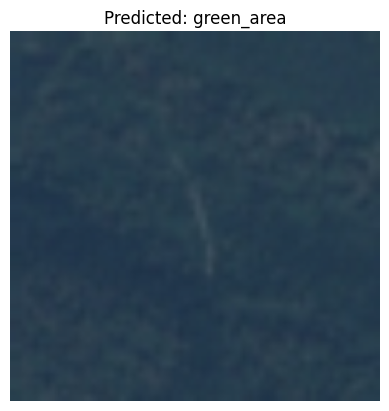


Predicted Class: green_area
Confidence Scores:
cloudy: 0.18%
desert: 0.00%
green_area: 99.82%
water: 0.00%


Enter the path to your satellite image (or 'quit' to exit):  data/water/SeaLake_16.jpg


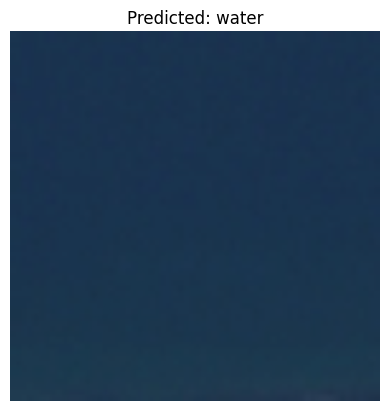


Predicted Class: water
Confidence Scores:
cloudy: 1.25%
desert: 1.13%
green_area: 0.34%
water: 97.28%


KeyboardInterrupt: Interrupted by user

In [15]:

import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
# Function to classify an image
def classify_image(image_path):
    # Define the image transformation inside the function
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match training input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Check if the image path exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)[0]  # Convert logits to probabilities
        predicted_idx = torch.argmax(probabilities).item()
        predicted_class = class_names[predicted_idx]
    
    # Denormalize image for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_display = image_tensor.squeeze(0).cpu() * std + mean  # Denormalize
    image_display = image_display.permute(1, 2, 0).numpy()  # Convert to HWC for plotting
    image_display = image_display.clip(0, 1)  # Ensure values are in [0, 1]

    # Visualize the image with prediction
    plt.imshow(image_display)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    # Print confidence scores
    print(f"\nPredicted Class: {predicted_class}")
    print("Confidence Scores:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probabilities[i].item() * 100:.2f}%")

# Main script for user input
def main():
    print("Satellite Image Classifier")
    print("-------------------------")
    while True:
        # Get image path from user
        image_path = input("Enter the path to your satellite image (or 'quit' to exit): ")
        if image_path.lower() == "quit":
            print("Exiting...")
            break
        
        try:
            classify_image(image_path)
        except Exception as e:
            print(f"Error: {e}")
            print("Please try again with a valid image path.")

if __name__ == "__main__":
    main()